# FWI of the Volve synthetic data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt, resample
from skimage.metrics import structural_similarity as ssim
import gc
import os
import time
import datetime
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import deepwave
import warnings
warnings.filterwarnings('ignore')
import deepinvhessian.fwi as fwi
from deepinvhessian.utilities import *
from deepinvhessian.filters import *
from deepinvhessian.train import *
from deepinvhessian.masks import *
from unet import *

In [2]:
set_seed(14)

# https://stackoverflow.com/questions/48152674/how-do-i-check-if-pytorch-is-using-the-gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Model, geometry, and data

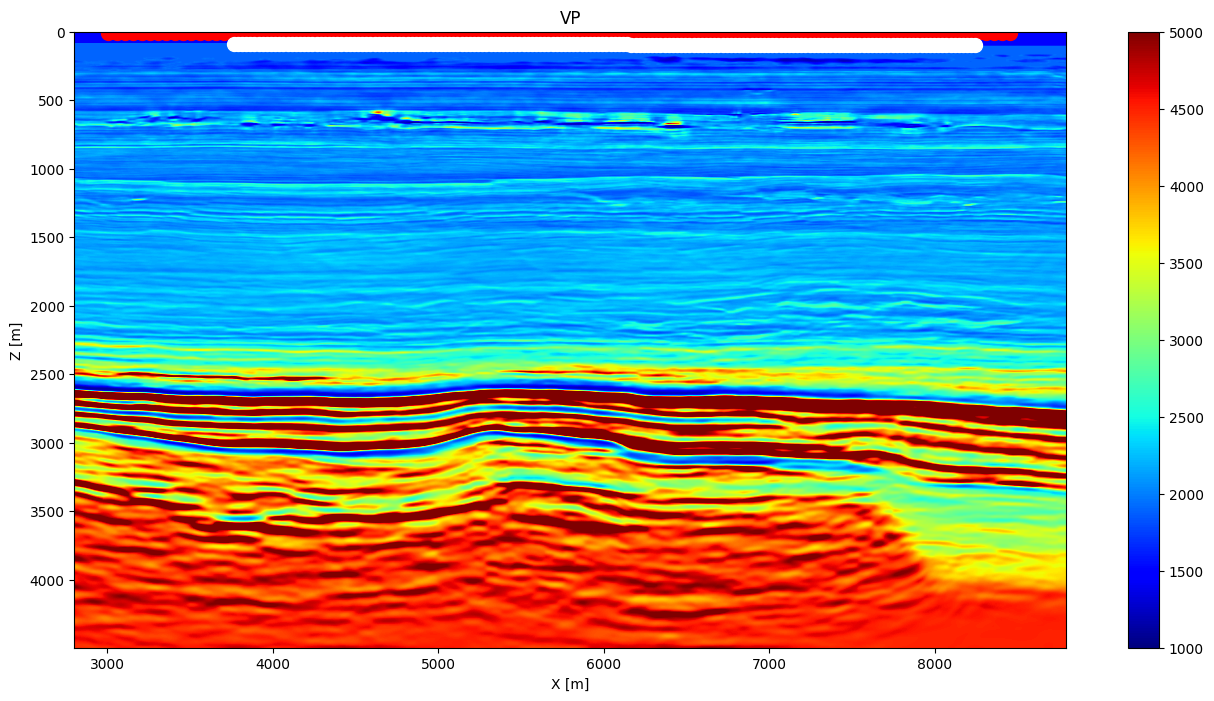

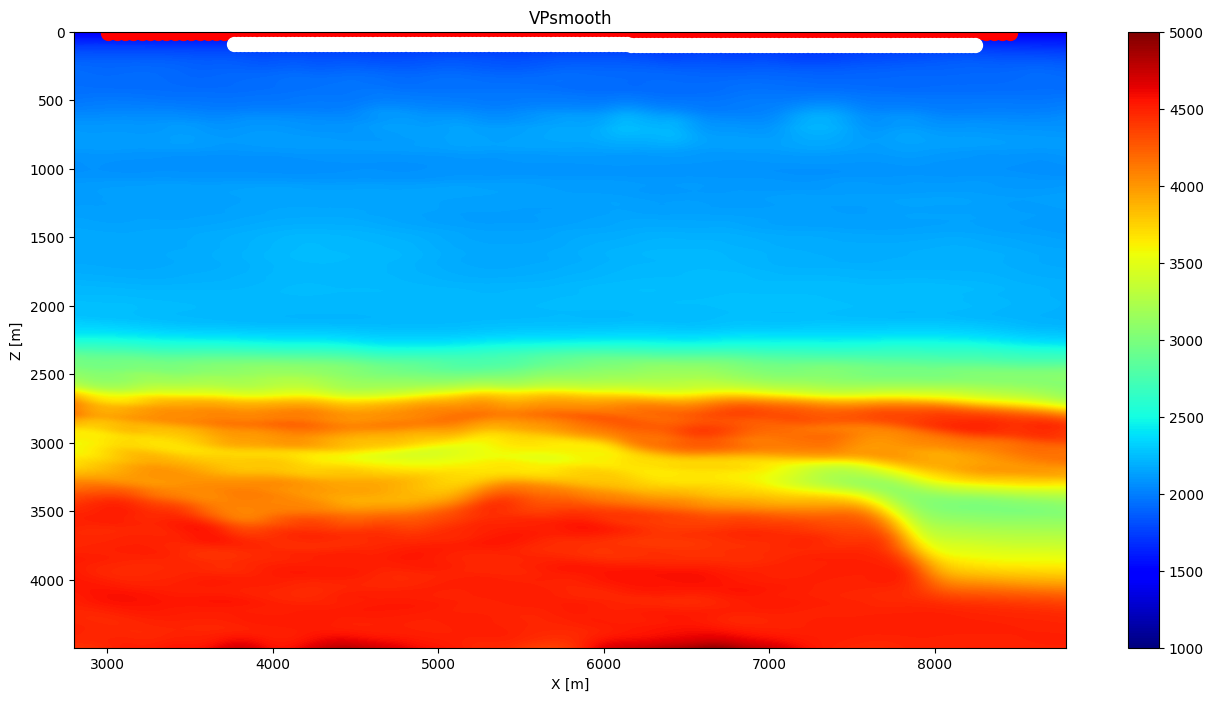

In [4]:
# Load from input file
inputdata = np.load('../data/input_nofs_full_volvesynth.npz')

# Velocity 
vel = inputdata["vel"].T

# Smooth velocity
nsmooth = 41
smooth = np.ones(nsmooth)/nsmooth
velsm = filtfilt(smooth, 1, filtfilt(smooth, 1, vel).T).T
 
nx, nz = vel.shape
x = inputdata["x"]
z = inputdata["z"]
s = inputdata["s"]
r = inputdata["r"]
ns, nr = s.shape[1], r.shape[1]
nx, nz = x.size, z.size

t = inputdata['t']
dt = t[1]
d = inputdata['p'].transpose(0, 2, 1)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
im = ax.imshow(vel.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VP')
ax.axis('tight')
plt.colorbar(im);

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
im = ax.imshow(velsm.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VPsmooth')
ax.axis('tight')
plt.colorbar(im);

## Convert from global to local grid

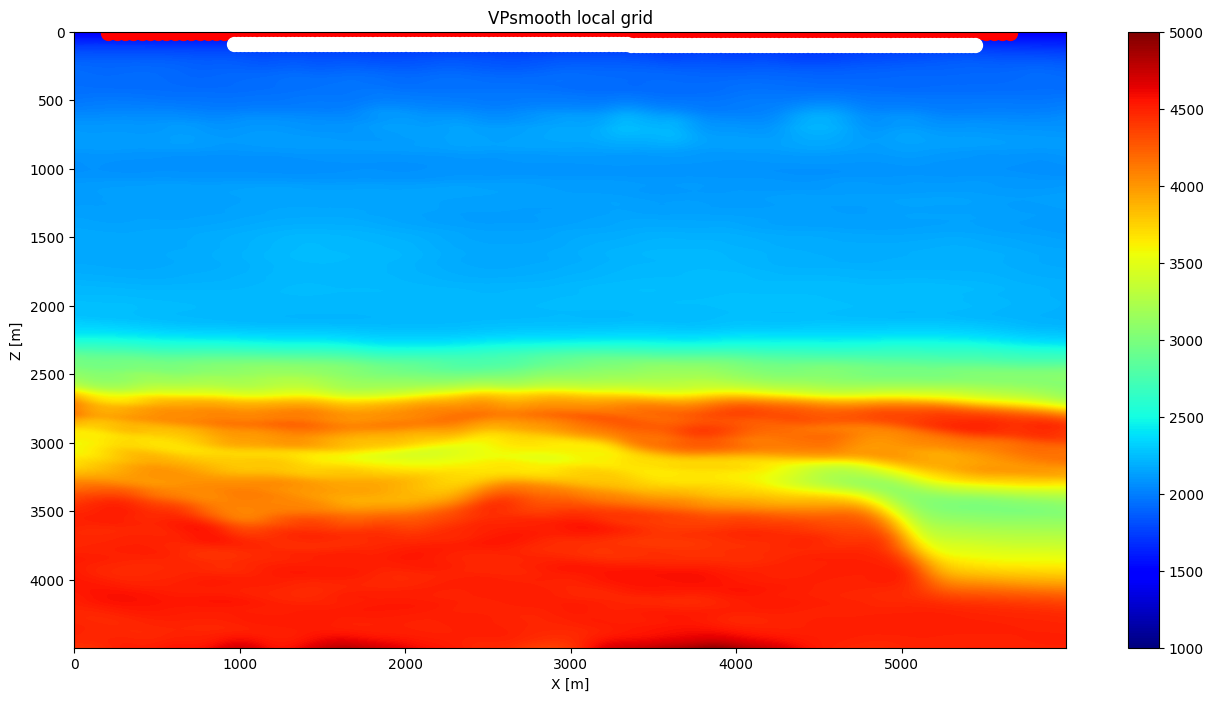

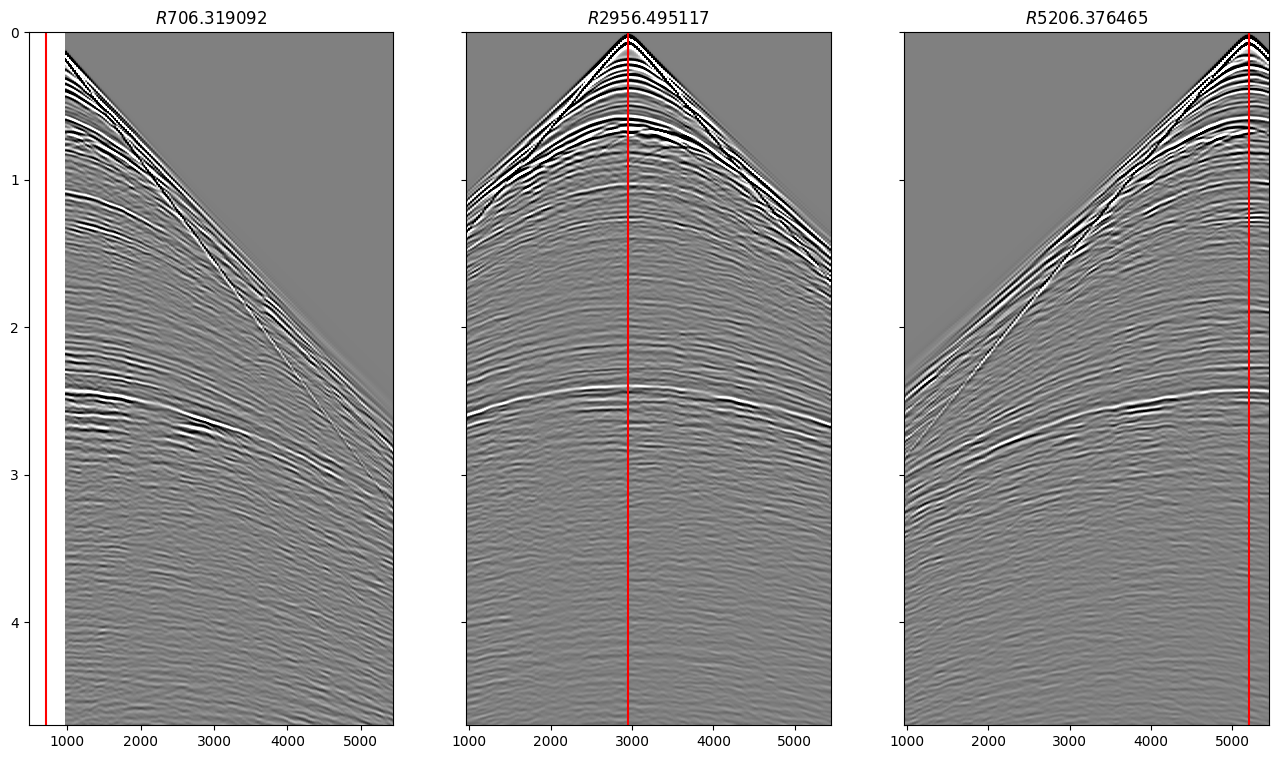

In [5]:
xorig = x[0]
x -= xorig
dx, dz = x[1], z[1]

s[0] -= xorig
r[0] -= xorig

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
im = ax.imshow(velsm.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VPsmooth local grid')
ax.axis('tight')
plt.colorbar(im)

clip = 0.02
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(d[10].T, cmap='gray', vmin=-clip*np.abs(d).max(), vmax=clip*np.abs(d).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].axvline(s[0, 10], color='r')
axs[0].set_title(r'$R%f$' % s[0, 10])
axs[0].axis('tight')
axs[1].imshow(d[ns//2].T, cmap='gray', vmin=-clip*np.abs(d).max(), vmax=clip*np.abs(d).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].axvline(s[0, ns//2], color='r')
axs[1].set_title(r'$R%f$' % s[0, ns//2])
axs[1].axis('tight')
axs[2].imshow(d[-10].T, cmap='gray', vmin=-clip*np.abs(d).max(), vmax=clip*np.abs(d).max(),
              extent = (r[0,0],r[0,-1], t[-1], t[0]))
axs[2].axvline(s[0, -10], color='r')
axs[2].set_title(r'$R%f$' % s[0, -10])
axs[2].axis('tight');

In [6]:
# Resample data
print(d.shape)
d2 = resample(d, d.shape[-1]*2, axis=-1)
print(d2.shape)

(110, 180, 2351)
(110, 180, 4702)


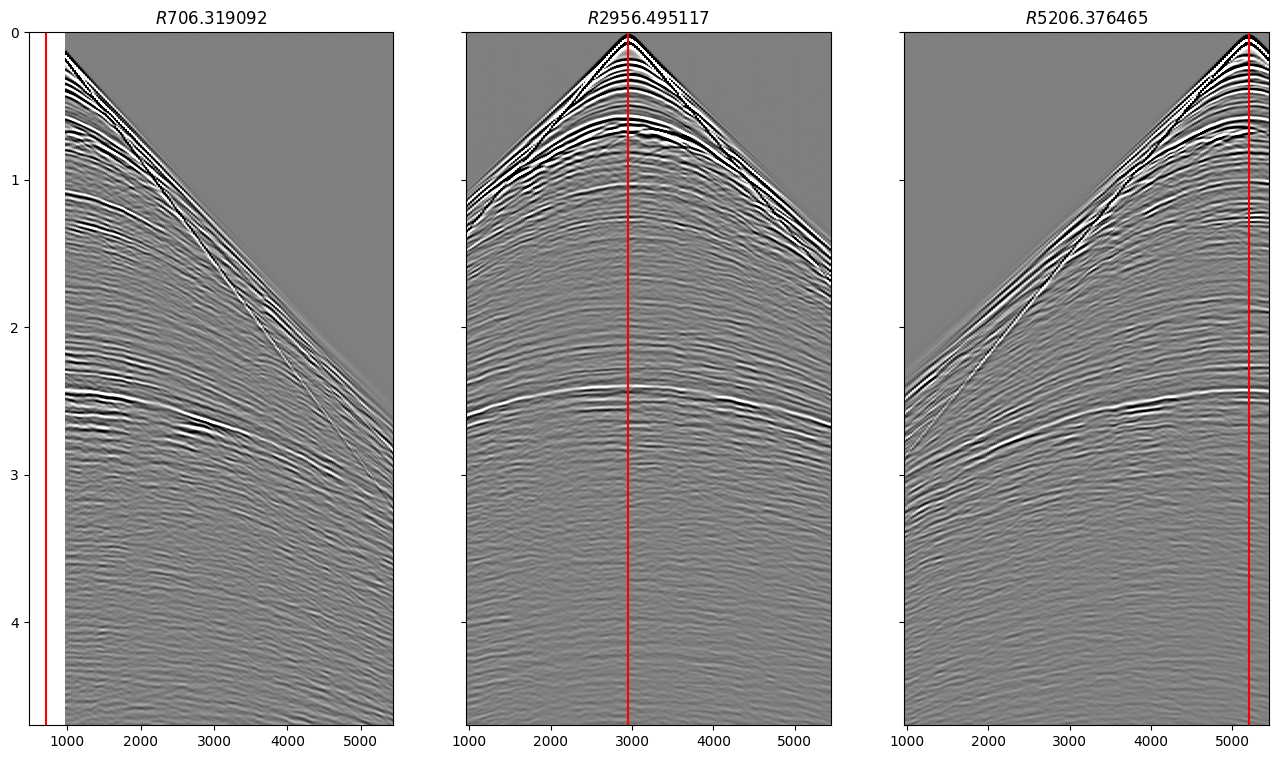

In [7]:
# Visualize data
clip = 0.02
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(d2[10].T, cmap='gray', vmin=-clip*np.abs(d2).max(), vmax=clip*np.abs(d2).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].axvline(s[0, 10], color='r')
axs[0].set_title(r'$R%f$' % s[0, 10])
axs[0].axis('tight')
axs[1].imshow(d2[ns//2].T, cmap='gray', vmin=-clip*np.abs(d2).max(), vmax=clip*np.abs(d2).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].axvline(s[0, ns//2], color='r')
axs[1].set_title(r'$R%f$' % s[0, ns//2])
axs[1].axis('tight')
axs[2].imshow(d2[-10].T, cmap='gray', vmin=-clip*np.abs(d2).max(), vmax=clip*np.abs(d2).max(),
              extent = (r[0,0],r[0,-1], t[-1], t[0]))
axs[2].axvline(s[0, -10], color='r')
axs[2].set_title(r'$R%f$' % s[0, -10])
axs[2].axis('tight');

In [8]:
# Rescale models 
model_init = cv2.resize(velsm.T, (480, 360))
model_init = torch.tensor(model_init).float()
model_true = cv2.resize(vel.T, (480, 360))

In [9]:
par = {
        # model parameters
        'nx':480,   'dx':12.5,  'ox':0,
        'nz':360,   'dz':12.5,  'oz':0,
        'nr':180,   'dr':torch.tensor(r[0]),  'orec':0,  'rz':torch.tensor(r[1]),
        'num_shots':110,   'ds':torch.tensor(s[0]),  'os':0,  'sz':torch.tensor(s[1]),
        'nt':4702,  'dt':0.001,  'ot':0,
        'num_sources_per_shot': 1, 'num_receivers_per_shot': 180,
        'num_dims':2,
        'num_batches':110,
        'freq': 7
}

# Load the wavelet estimated from the data
wavelet = np.load(f'estimated_wavelets/Volve_synthetic/wav_7Hz.npz')['wav']

In [10]:
# Initialize the FWI class
params = fwi.FWIParams(par,torch.tensor(wavelet[:par['nt']]), 'volve_synthetic')
# Get the source receiver coordinates
x_s1, x_r1 = params.get_coordinate('volve_synthetic')
# Create a wavelet for every source
source_amplitudes = params.create_wavelet(torch.tensor(wavelet[:par['nt']]))

Text(0.5, 1.0, 'Source wavelet')

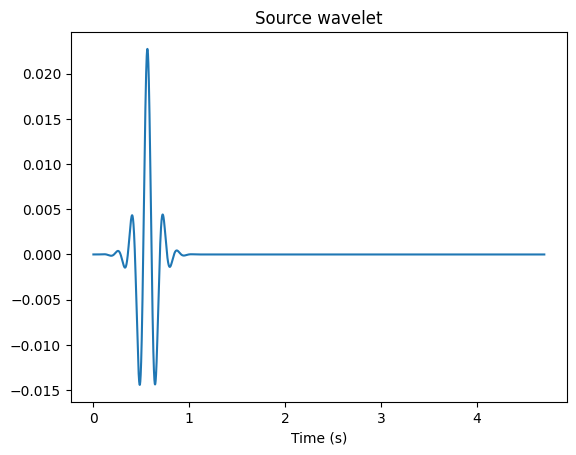

In [11]:
# Visualize the source wavelet
plt.plot(np.arange(0,par['nt'])*par['dt'], source_amplitudes[0, 0, :])
plt.xlabel('Time (s)')
plt.title('Source wavelet')

In [12]:
# Simulate the true data
data_true = fwi.forward_modelling(params, torch.tensor(model_true).float(), device)

## Run FWI with the Barzilai-Borwein method

In [13]:
# Create folder to save the results
exp_name = 'Exp_VolveSynthetic_BB'
if os.path.isdir(exp_name) is False:
    os.makedirs(exp_name)

In [20]:
# Run conventional FWI with the Barzilai-Borwein method

# Move data to GPU if using GPU
model = model_init.clone().to(device)
model.requires_grad = True
data_true = torch.tensor(data_true).float()
# Create lists to save results
gradients, updates, fwi_loss, ssim_list, alphas = [], [], [], [], []
# Create mask to mask strong amplitudes around the sources in the update
mask = torch.ones_like(model)
mask[:25] = 0
# Misfit function to run FWI
loss_fn = nn.MSELoss()

data_range = model_true.max() - model_true.min()
step_size = 1e3
alphas.append(step_size)
optimizer = torch.optim.SGD([{'params': [model], 'lr': step_size,}]) # Optimizer to run FWI with step size: lr
tsamples = 0 # Number of time samples starting from zero to exclude from computing the misfit
FWI_iter = 60 # Number of FWI iterations
t_start = time.time()
for iteration in tqdm(range(FWI_iter)):
    # Compute the structural similarity index measure (ssim) between the current and the true models
    ssim_metric = ssim(model.detach().cpu().numpy(), model_true, data_range=data_range)
    ssim_list.append(ssim_metric)
    # Compute FWI gradient
    optimizer.zero_grad()
    grad, iter_loss = fwi.compute_gradient(params, model, data_true, loss_fn, tsamples, device)
    fwi_loss.append(iter_loss)
    print(f'FWI iteration: {iteration} loss = {fwi_loss[-1]}, SSIM = {ssim_list[-1]}')
    # Clip the gradient values
    torch.nn.utils.clip_grad_value_(model, torch.quantile(grad.detach().abs(), 0.98))
    if iteration == 0: gmax0 =  torch.abs(grad.detach()).max()
    # Normalize the gradient, mask it around the sources and apply taperinh to the shallower and deeper parts
    grad = (grad /gmax0) * mask
    gradients.append(grad.cpu().detach().numpy())
    # Calculate the step size
    if iteration > 0:
        delta_model = model.detach().clone() - previous_model
        delta_grad = grad.detach().clone() - previous_grad
        alpha = fwi.bb_step(delta_model, delta_grad, 'short')
        alphas.append(alpha)
        print(f'alpha = {alpha}')
        optimizer.param_groups[-1]['lr'] = alpha
    # Save the current solution and gradient for calculating the step size in the next iteration
    previous_model = model.detach().clone()
    previous_grad = grad.detach().clone()
    # Update the model
    model.grad.data[:] = grad
    optimizer.step()
    updates.append(model.detach().clone().cpu().numpy())
    # Plot the results
    # show_one_iter_fwi(grad.cpu(), model.detach().cpu(), iteration=iteration,
    #             cmap='bwr', vmin=1000, vmax=5000, extent=(0, 6000, 4500, 0), save_path=f'{exp_name}')
t_end = time.time()
t_delta = t_end - t_start
print(f'Runtime:{datetime.timedelta(seconds=t_delta)}')
# Save the results
np.savez(f'{exp_name}/losses', 
         fwi_loss=np.array(fwi_loss), 
         ssim=np.array(ssim_list),
         alphas=np.array(alphas)
         )
np.savez(f'{exp_name}/results', 
         updates=np.array(updates),
           gradients=np.array(gradients),
           )

  0%|          | 0/60 [00:00<?, ?it/s]

FWI iteration: 0 loss = 6.653965475296983e-05, SSIM = 0.4143362193052805
FWI iteration: 1 loss = 5.6422913753935556e-05, SSIM = 0.41761019353075546
alpha = 2298.35498046875
FWI iteration: 2 loss = 5.3432280269176275e-05, SSIM = 0.42420934824668
alpha = 843.2098999023438
FWI iteration: 3 loss = 4.850046848745974e-05, SSIM = 0.4255639430789773
alpha = 721.9703979492188
FWI iteration: 4 loss = 4.7490003039869904e-05, SSIM = 0.42697773085288804
alpha = 975.5967407226562
FWI iteration: 5 loss = 4.645770879340654e-05, SSIM = 0.42863561376767756
alpha = 3412.63671875
FWI iteration: 6 loss = 4.3586919690080154e-05, SSIM = 0.4333776527331498
alpha = 6722.3056640625
FWI iteration: 7 loss = 4.019938212216154e-05, SSIM = 0.4388547946296951
alpha = 5107.4150390625
FWI iteration: 8 loss = 3.9795643103637056e-05, SSIM = 0.4404113452894505
alpha = 881.4230346679688
FWI iteration: 9 loss = 3.832290843671548e-05, SSIM = 0.440933260963994
alpha = 814.3208618164062
FWI iteration: 10 loss = 3.8100701369165

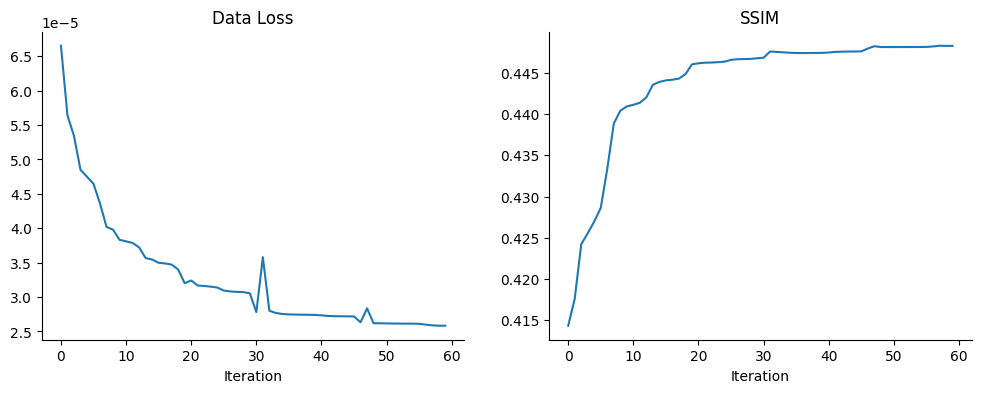

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(fwi_loss)
axs[0].set_title('Data Loss')
axs[0].set_xlabel('Iteration')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].plot(ssim_list)
axs[1].set_title('SSIM')
axs[1].set_xlabel('Iteration')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
plt.savefig(f'{exp_name}/losses.png',  bbox_inches='tight', dpi=300)

## Run FWI with the proposed approach $\delta m$

  0%|          | 0/110 [00:00<?, ?it/s]

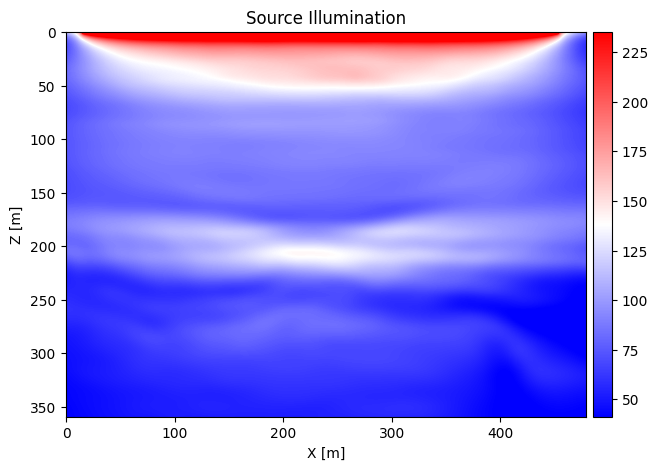

14508

In [22]:
SI = fwi.source_illumination(model_init, params.source_amplitudes, par['dx'], par['dt'], x_s1, device=device)
simin, simax = np.percentile(SI.cpu(), [2,98])
show_model(SI.cpu(), cmap='bwr', vmin=simin, vmax=simax, figsize=(8, 5),
           title='Source Illumination')
torch.cuda.empty_cache()
gc.collect()

In [14]:
exp_name = 'Exp_VolveSynthetic_dm'
if os.path.isdir(exp_name) is False:
    os.makedirs(exp_name)

In [25]:
# Run conventional FWI with the proposed method

# Move data to GPU if using GPU
model = model_init.clone().to(device)
model.requires_grad = True
data_true = torch.tensor(data_true).float()
# Create lists to save results
gradients, dm1s, gradients_pred, dms, updates, fwi_loss, vel_loss, network_loss, ssim_list, = [], [], [], [], [], [], [], [], []

mask = torch.ones_like(model)
mask[:25] = 0
taper = cosine_taper(nz=par['nz'], nx=par['nx'], top_width=100, bottom_width=200)
taper = torch.tensor(taper).float().to(device)

loss_fn = nn.MSELoss() # Misfit function for FWI and Born modelling
optimizer = torch.optim.SGD([{'params': [model], 'lr': 5e2,}]) # Optimizer to run FWI with step size: lr
# Create the network, its optimizer and the loss function to train it
network = UNet(n_channels=1, n_classes=1, hidden_channels=256).to(device)
optimizer_unet = torch.optim.Adam(network.parameters(), lr=1e-4)
l2_norm = nn.MSELoss() # Loss function for the network
network_iter_init = 1000 # Number of epochs to train the network in the first FWI iteration
network_iter_fin = 150 # Number of epochs to train the network in every FWI iteration except the first one

data_range = model_true.max() - model_true.min()
tsamples = 0 # Number of time samples starting from zero to exclude from computing the misfit
FWI_iter = 30 # Number of FWI iterations

t_start = time.time()
for iteration in tqdm(range(FWI_iter)):
    ssim_metric = ssim(model.detach().cpu().numpy(), model_true, data_range=data_range)
    ssim_list.append(ssim_metric)
    # Compute FWI gradient
    optimizer.zero_grad()
    grad, iter_loss = fwi.compute_gradient(params, model, data_true, loss_fn, tsamples, device)
    fwi_loss.append(iter_loss)
    print(f'FWI iteration: {iteration} loss = {fwi_loss[-1]}, SSIM = {ssim_list[-1]}')
    # Clip the gradient values
    torch.nn.utils.clip_grad_value_(model, torch.quantile(grad.detach().abs(), 0.98))
    # Apply source illumination to the gradient
    grad = (grad * model.detach().clone()**3 ) / SI
    if iteration == 0: gmax0 =  torch.abs(grad.detach()).max()
    # Normalize the gradient, mask it around the sources and apply taperinh to the shallower and deeper parts
    grad = (grad /gmax0) * mask * taper
    gradients.append(grad.cpu().detach().numpy())
    # Compute dm1 with the gradient as the perturbation
    dm1 = grad.detach().clone().float().to(device)
    dm1.requires_grad = True
    dm1 = fwi.compute_dm1(params, model.detach().clone(), dm1 , loss_fn, tsamples, device)
    # Apply source illumination to dm1
    dm1 = dm1 * (model.detach().clone() ** 3) / SI
    if iteration == 0: dm1max0 =  1e1*torch.abs(dm1.detach()).max()
    # Normalize dm1 and mask it around the sources
    dm1 = (dm1 / dm1max0)  * mask
    # Train the network
    training_pair = {'x': dm1.clone().unsqueeze(0).unsqueeze(0),
                     'y': grad.clone().unsqueeze(0).unsqueeze(0)}
    network_iter = network_iter_init if iteration == 0 else network_iter_fin
    lossn = train(network, training_pair, optimizer_unet, l2_norm, network_iter, use_scheduler=True, device=device)
    network_loss.extend(lossn)
    # Get the gradient from the network
    with torch.no_grad():
        g = network(training_pair['x']).squeeze() * mask
    gradients_pred.append(g.cpu().detach().numpy())
    # Get dm from the network
    with torch.no_grad():
        dm = network(training_pair['y']).squeeze() * mask
    dms.append(dm.cpu().detach().numpy())
    # Update the model
    model.grad.data[:] = dm.detach().clone()
    optimizer.param_groups[-1]['lr'] = 1e2 if iteration < 10 else 1e2
    optimizer.step()
    updates.append(model.detach().clone().cpu().numpy())
    # Plot the results
    # show_one_iter_dm(grad.cpu(), dm1.cpu(), g.cpu(), dm.cpu(), model.detach().cpu(), lossn, iteration=iteration,
    #             cmap='bwr', vmin=1000, vmax=5000, extent=(0, 6000, 4500, 0), save_path=f'{exp_name}')
t_end = time.time()
t_delta = t_end - t_start
print(f'Runtime:{datetime.timedelta(seconds=t_delta)}')
# Save the results
np.savez(f'{exp_name}/losses', fwi_loss=np.array(fwi_loss),
                               network_loss=np.array(network_loss),
                               ssim_list=np.array(ssim_list),
                               )
np.savez(f'{exp_name}/dms', updates=np.array(updates), 
                            gradients=np.array(gradients), 
                            dm1s=np.array(dm1s),
                            gradients_pred=np.array(gradients_pred),
                            dms=np.array(dms),
                            )

torch.save(network.state_dict(), f'{exp_name}/network_weights.pth')

  0%|          | 0/30 [00:00<?, ?it/s]

FWI iteration: 0 loss = 6.653965475296983e-05, SSIM = 0.4143362193052805


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0060965451411902905
Training Epoch 1, Loss = 0.005147993098944426
Training Epoch 2, Loss = 0.004346500616520643
Training Epoch 3, Loss = 0.003640743438154459
Training Epoch 4, Loss = 0.003299088217318058
Training Epoch 5, Loss = 0.0035609521437436342
Training Epoch 6, Loss = 0.0034359206911176443
Training Epoch 7, Loss = 0.0030624717473983765
Training Epoch 8, Loss = 0.002760769333690405
Training Epoch 9, Loss = 0.002601679414510727
Training Epoch 10, Loss = 0.00254669482819736
Training Epoch 11, Loss = 0.002526708645746112
Training Epoch 12, Loss = 0.0024934187531471252
Training Epoch 13, Loss = 0.0024232221767306328
Training Epoch 14, Loss = 0.0023165890015661716
Training Epoch 15, Loss = 0.0021885945461690426
Training Epoch 16, Loss = 0.002060564234852791
Training Epoch 17, Loss = 0.0019549657590687275
Training Epoch 18, Loss = 0.0019104101229459047
Training Epoch 19, Loss = 0.001972765661776066
Training Epoch 20, Loss = 0.0020023442339152098
Training Epoc

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00027560986927710474
Training Epoch 1, Loss = 0.00023177744878921658
Training Epoch 2, Loss = 0.00018232048023492098
Training Epoch 3, Loss = 0.00015198356413748115
Training Epoch 4, Loss = 0.00013865109940525144
Training Epoch 5, Loss = 0.00012991446419619024
Training Epoch 6, Loss = 0.00012153241550549865
Training Epoch 7, Loss = 0.00011478047963464633
Training Epoch 8, Loss = 0.00010892142017837614
Training Epoch 9, Loss = 0.00010165732237510383
Training Epoch 10, Loss = 9.233660239260644e-05
Training Epoch 11, Loss = 8.26711329864338e-05
Training Epoch 12, Loss = 7.525058754254133e-05
Training Epoch 13, Loss = 7.145033305278048e-05
Training Epoch 14, Loss = 7.014969742158428e-05
Training Epoch 15, Loss = 6.873536767670885e-05
Training Epoch 16, Loss = 6.563448550878093e-05
Training Epoch 17, Loss = 6.151674460852519e-05
Training Epoch 18, Loss = 5.799028440378606e-05
Training Epoch 19, Loss = 5.5714855989208445e-05
Training Epoch 20, Loss = 5.420574962045

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0019152231980115175
Training Epoch 1, Loss = 0.000607786001637578
Training Epoch 2, Loss = 0.0005082243005745113
Training Epoch 3, Loss = 0.0005148020572960377
Training Epoch 4, Loss = 0.0005266073276288807
Training Epoch 5, Loss = 0.0005145538016222417
Training Epoch 6, Loss = 0.00041968878940679133
Training Epoch 7, Loss = 0.00044973051990382373
Training Epoch 8, Loss = 0.0003885370388161391
Training Epoch 9, Loss = 0.00035279596340842545
Training Epoch 10, Loss = 0.00037733017234131694
Training Epoch 11, Loss = 0.00033085414906963706
Training Epoch 12, Loss = 0.0003267883148510009
Training Epoch 13, Loss = 0.00033961195731535554
Training Epoch 14, Loss = 0.0003187967522535473
Training Epoch 15, Loss = 0.00030478823464363813
Training Epoch 16, Loss = 0.00031501901685260236
Training Epoch 17, Loss = 0.00030072039226070046
Training Epoch 18, Loss = 0.00028230040334165096
Training Epoch 19, Loss = 0.00028269935864955187
Training Epoch 20, Loss = 0.000275122263

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00017964305880013853
Training Epoch 1, Loss = 0.00017149433551821858
Training Epoch 2, Loss = 0.0001611411280464381
Training Epoch 3, Loss = 0.00015150813851505518
Training Epoch 4, Loss = 0.00014164234744384885
Training Epoch 5, Loss = 0.00013110031432006508
Training Epoch 6, Loss = 0.00012184073420939967
Training Epoch 7, Loss = 0.00011537352838786319
Training Epoch 8, Loss = 0.00011016573262168095
Training Epoch 9, Loss = 0.00010430347902001813
Training Epoch 10, Loss = 9.876037074718624e-05
Training Epoch 11, Loss = 9.524643246550113e-05
Training Epoch 12, Loss = 9.333164780400693e-05
Training Epoch 13, Loss = 9.161996422335505e-05
Training Epoch 14, Loss = 8.984275336842984e-05
Training Epoch 15, Loss = 8.853224426275119e-05
Training Epoch 16, Loss = 8.731448906473815e-05
Training Epoch 17, Loss = 8.51374352350831e-05
Training Epoch 18, Loss = 8.212709508370608e-05
Training Epoch 19, Loss = 7.942577940411866e-05
Training Epoch 20, Loss = 7.73714345996268

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.732454494340345e-05
Training Epoch 1, Loss = 6.551347905769944e-05
Training Epoch 2, Loss = 6.295488128671423e-05
Training Epoch 3, Loss = 6.022462548571639e-05
Training Epoch 4, Loss = 5.76451639062725e-05
Training Epoch 5, Loss = 5.569921631831676e-05
Training Epoch 6, Loss = 5.4598353017354384e-05
Training Epoch 7, Loss = 5.3928968554828316e-05
Training Epoch 8, Loss = 5.328158658812754e-05
Training Epoch 9, Loss = 5.262107151793316e-05
Training Epoch 10, Loss = 5.196551501285285e-05
Training Epoch 11, Loss = 5.123905066284351e-05
Training Epoch 12, Loss = 5.0486989493947476e-05
Training Epoch 13, Loss = 4.9854184908326715e-05
Training Epoch 14, Loss = 4.934866592520848e-05
Training Epoch 15, Loss = 4.8854013584787026e-05
Training Epoch 16, Loss = 4.833525963476859e-05
Training Epoch 17, Loss = 4.7838697355473414e-05
Training Epoch 18, Loss = 4.735763286589645e-05
Training Epoch 19, Loss = 4.686905231210403e-05
Training Epoch 20, Loss = 4.6414181269938126e

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.340297841234133e-05
Training Epoch 1, Loss = 6.00253879383672e-05
Training Epoch 2, Loss = 5.773384327767417e-05
Training Epoch 3, Loss = 5.637657886836678e-05
Training Epoch 4, Loss = 5.4233889386523515e-05
Training Epoch 5, Loss = 5.241570033831522e-05
Training Epoch 6, Loss = 5.165772745385766e-05
Training Epoch 7, Loss = 5.038069866714068e-05
Training Epoch 8, Loss = 4.84707961732056e-05
Training Epoch 9, Loss = 4.741074735647999e-05
Training Epoch 10, Loss = 4.6759032557019964e-05
Training Epoch 11, Loss = 4.5485088776331395e-05
Training Epoch 12, Loss = 4.4428077671909705e-05
Training Epoch 13, Loss = 4.398003875394352e-05
Training Epoch 14, Loss = 4.309631549404003e-05
Training Epoch 15, Loss = 4.2034567741211504e-05
Training Epoch 16, Loss = 4.145110142417252e-05
Training Epoch 17, Loss = 4.080273356521502e-05
Training Epoch 18, Loss = 4.005245500593446e-05
Training Epoch 19, Loss = 3.9726102841086686e-05
Training Epoch 20, Loss = 3.9464277506340295e-

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0006557720480486751
Training Epoch 1, Loss = 0.0005613468238152564
Training Epoch 2, Loss = 0.00016650020552333444
Training Epoch 3, Loss = 0.00029814496519975364
Training Epoch 4, Loss = 0.0002102809230564162
Training Epoch 5, Loss = 0.00014312579878605902
Training Epoch 6, Loss = 0.00015933808754198253
Training Epoch 7, Loss = 0.00017228243814315647
Training Epoch 8, Loss = 0.00015215632447507232
Training Epoch 9, Loss = 0.00013267708709463477
Training Epoch 10, Loss = 0.00013004378706682473
Training Epoch 11, Loss = 0.0001352274848613888
Training Epoch 12, Loss = 0.00013684578880202025
Training Epoch 13, Loss = 0.00013095507165417075
Training Epoch 14, Loss = 0.00011989640188403428
Training Epoch 15, Loss = 0.00010839085007319227
Training Epoch 16, Loss = 0.0001001633281703107
Training Epoch 17, Loss = 9.618524927645922e-05
Training Epoch 18, Loss = 9.475473780184984e-05
Training Epoch 19, Loss = 9.324215352535248e-05
Training Epoch 20, Loss = 9.0197681856

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0001390682446071878
Training Epoch 1, Loss = 0.00013434559514280409
Training Epoch 2, Loss = 0.00012695755867753178
Training Epoch 3, Loss = 0.00011896495561813936
Training Epoch 4, Loss = 0.00011157178960274905
Training Epoch 5, Loss = 0.00010513257439015433
Training Epoch 6, Loss = 9.978040179703385e-05
Training Epoch 7, Loss = 9.570104157319292e-05
Training Epoch 8, Loss = 9.296755160903558e-05
Training Epoch 9, Loss = 9.141021291725338e-05
Training Epoch 10, Loss = 9.06016502995044e-05
Training Epoch 11, Loss = 8.999399869935587e-05
Training Epoch 12, Loss = 8.912532939575613e-05
Training Epoch 13, Loss = 8.775876631261781e-05
Training Epoch 14, Loss = 8.590039215050638e-05
Training Epoch 15, Loss = 8.373521995963529e-05
Training Epoch 16, Loss = 8.149231143761426e-05
Training Epoch 17, Loss = 7.933916640467942e-05
Training Epoch 18, Loss = 7.73499850765802e-05
Training Epoch 19, Loss = 7.555970660177991e-05
Training Epoch 20, Loss = 7.401229231618345e-05

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0010458671022206545
Training Epoch 1, Loss = 0.0006692787283100188
Training Epoch 2, Loss = 0.00032914348412305117
Training Epoch 3, Loss = 0.0002303793007740751
Training Epoch 4, Loss = 0.0002226247888756916
Training Epoch 5, Loss = 0.00021725879923906177
Training Epoch 6, Loss = 0.00020575191592797637
Training Epoch 7, Loss = 0.00019454538414720446
Training Epoch 8, Loss = 0.00018594331049825996
Training Epoch 9, Loss = 0.00017807238327804953
Training Epoch 10, Loss = 0.00016893286374397576
Training Epoch 11, Loss = 0.00015831226482987404
Training Epoch 12, Loss = 0.0001474845048505813
Training Epoch 13, Loss = 0.00013802172907162458
Training Epoch 14, Loss = 0.0001307928323512897
Training Epoch 15, Loss = 0.0001255522365681827
Training Epoch 16, Loss = 0.00012134786084061489
Training Epoch 17, Loss = 0.00011717354936990887
Training Epoch 18, Loss = 0.00011246608482906595
Training Epoch 19, Loss = 0.00010724826279329136
Training Epoch 20, Loss = 0.000102016

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0001099159344448708
Training Epoch 1, Loss = 9.452829544898123e-05
Training Epoch 2, Loss = 7.576018833788112e-05
Training Epoch 3, Loss = 6.386127643054351e-05
Training Epoch 4, Loss = 6.0872745962115005e-05
Training Epoch 5, Loss = 6.277673674048856e-05
Training Epoch 6, Loss = 6.444018799811602e-05
Training Epoch 7, Loss = 6.298927473835647e-05
Training Epoch 8, Loss = 5.860213786945678e-05
Training Epoch 9, Loss = 5.3440529882209376e-05
Training Epoch 10, Loss = 4.9801259592641145e-05
Training Epoch 11, Loss = 4.8565532779321074e-05
Training Epoch 12, Loss = 4.8795958718983456e-05
Training Epoch 13, Loss = 4.8679299652576447e-05
Training Epoch 14, Loss = 4.709613131126389e-05
Training Epoch 15, Loss = 4.443347279448062e-05
Training Epoch 16, Loss = 4.1971681639552116e-05
Training Epoch 17, Loss = 4.06370272685308e-05
Training Epoch 18, Loss = 4.03144076699391e-05
Training Epoch 19, Loss = 4.0176753827836365e-05
Training Epoch 20, Loss = 3.949426900362596e

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00011630718654487282
Training Epoch 1, Loss = 0.00011338219337631017
Training Epoch 2, Loss = 0.00010883315553655848
Training Epoch 3, Loss = 0.00010396188008598983
Training Epoch 4, Loss = 9.93435678537935e-05
Training Epoch 5, Loss = 9.48960441746749e-05
Training Epoch 6, Loss = 9.03879918041639e-05
Training Epoch 7, Loss = 8.592586527811363e-05
Training Epoch 8, Loss = 8.189077925635502e-05
Training Epoch 9, Loss = 7.86365635576658e-05
Training Epoch 10, Loss = 7.620282849529758e-05
Training Epoch 11, Loss = 7.429663673974574e-05
Training Epoch 12, Loss = 7.253376679727808e-05
Training Epoch 13, Loss = 7.070665014907718e-05
Training Epoch 14, Loss = 6.885833136038855e-05
Training Epoch 15, Loss = 6.715161725878716e-05
Training Epoch 16, Loss = 6.567726813955233e-05
Training Epoch 17, Loss = 6.436982948798686e-05
Training Epoch 18, Loss = 6.308549927780405e-05
Training Epoch 19, Loss = 6.17175901425071e-05
Training Epoch 20, Loss = 6.0266633227001876e-05
Tr

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00014050448953639716
Training Epoch 1, Loss = 0.0001100583394872956
Training Epoch 2, Loss = 9.127526573138312e-05
Training Epoch 3, Loss = 8.030599565245211e-05
Training Epoch 4, Loss = 7.012253627181053e-05
Training Epoch 5, Loss = 6.547183147631586e-05
Training Epoch 6, Loss = 6.3723222410772e-05
Training Epoch 7, Loss = 5.810648144688457e-05
Training Epoch 8, Loss = 4.9627473345026374e-05
Training Epoch 9, Loss = 4.3658208596752957e-05
Training Epoch 10, Loss = 4.125791383557953e-05
Training Epoch 11, Loss = 3.9913189539220184e-05
Training Epoch 12, Loss = 3.829436900559813e-05
Training Epoch 13, Loss = 3.700382148963399e-05
Training Epoch 14, Loss = 3.651277438621037e-05
Training Epoch 15, Loss = 3.604455923778005e-05
Training Epoch 16, Loss = 3.461360392975621e-05
Training Epoch 17, Loss = 3.2381900382461026e-05
Training Epoch 18, Loss = 3.0434195650741458e-05
Training Epoch 19, Loss = 2.953255534521304e-05
Training Epoch 20, Loss = 2.9483346224878915e-

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.144971196888946e-05
Training Epoch 1, Loss = 3.0515724574797787e-05
Training Epoch 2, Loss = 2.9022152375546284e-05
Training Epoch 3, Loss = 2.7386258807382546e-05
Training Epoch 4, Loss = 2.5881170586217195e-05
Training Epoch 5, Loss = 2.4596709408797324e-05
Training Epoch 6, Loss = 2.351845796511043e-05
Training Epoch 7, Loss = 2.2622441974817775e-05
Training Epoch 8, Loss = 2.1902358639636077e-05
Training Epoch 9, Loss = 2.1338031729101203e-05
Training Epoch 10, Loss = 2.0876248527201824e-05
Training Epoch 11, Loss = 2.0440493244677782e-05
Training Epoch 12, Loss = 1.9978408090537414e-05
Training Epoch 13, Loss = 1.9493010768201202e-05
Training Epoch 14, Loss = 1.903258998936508e-05
Training Epoch 15, Loss = 1.864479054347612e-05
Training Epoch 16, Loss = 1.8340993847232312e-05
Training Epoch 17, Loss = 1.8094769984600134e-05
Training Epoch 18, Loss = 1.7870797819341533e-05
Training Epoch 19, Loss = 1.765298111422453e-05
Training Epoch 20, Loss = 1.7446138

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.5399069525301456e-05
Training Epoch 1, Loss = 1.5244961105054244e-05
Training Epoch 2, Loss = 1.5019564671092667e-05
Training Epoch 3, Loss = 1.4789620763622224e-05
Training Epoch 4, Loss = 1.4584589735022746e-05
Training Epoch 5, Loss = 1.4405584806809202e-05
Training Epoch 6, Loss = 1.4250089407141786e-05
Training Epoch 7, Loss = 1.4120902960712556e-05
Training Epoch 8, Loss = 1.4015417036716826e-05
Training Epoch 9, Loss = 1.3918370314058848e-05
Training Epoch 10, Loss = 1.381296260660747e-05
Training Epoch 11, Loss = 1.3696670976059977e-05
Training Epoch 12, Loss = 1.35831578518264e-05
Training Epoch 13, Loss = 1.3487491742125712e-05
Training Epoch 14, Loss = 1.341242477792548e-05
Training Epoch 15, Loss = 1.3350085282581858e-05
Training Epoch 16, Loss = 1.3293456504470669e-05
Training Epoch 17, Loss = 1.3241428860055748e-05
Training Epoch 18, Loss = 1.3194081475376152e-05
Training Epoch 19, Loss = 1.3147785466571804e-05
Training Epoch 20, Loss = 1.309668

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.213065752381226e-05
Training Epoch 1, Loss = 1.2026415788568556e-05
Training Epoch 2, Loss = 1.187209454656113e-05
Training Epoch 3, Loss = 1.1710091712302528e-05
Training Epoch 4, Loss = 1.1563704902073368e-05
Training Epoch 5, Loss = 1.1440391062933486e-05
Training Epoch 6, Loss = 1.1340774108248297e-05
Training Epoch 7, Loss = 1.1260176506766584e-05
Training Epoch 8, Loss = 1.1189939868927468e-05
Training Epoch 9, Loss = 1.1123471267637797e-05
Training Epoch 10, Loss = 1.1060039469157346e-05
Training Epoch 11, Loss = 1.100198642234318e-05
Training Epoch 12, Loss = 1.0950273463095073e-05
Training Epoch 13, Loss = 1.0902866051765159e-05
Training Epoch 14, Loss = 1.0857254892471246e-05
Training Epoch 15, Loss = 1.081284699466778e-05
Training Epoch 16, Loss = 1.0770691915240604e-05
Training Epoch 17, Loss = 1.0732141163316555e-05
Training Epoch 18, Loss = 1.0697464858822059e-05
Training Epoch 19, Loss = 1.0666595699149184e-05
Training Epoch 20, Loss = 1.063981

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.507642062089872e-06
Training Epoch 1, Loss = 9.458819477003999e-06
Training Epoch 2, Loss = 9.401690476806834e-06
Training Epoch 3, Loss = 9.349633728561457e-06
Training Epoch 4, Loss = 9.295261406805366e-06
Training Epoch 5, Loss = 9.239469363819808e-06
Training Epoch 6, Loss = 9.192118341161404e-06
Training Epoch 7, Loss = 9.153705832432024e-06
Training Epoch 8, Loss = 9.116028195421677e-06
Training Epoch 9, Loss = 9.076643436856102e-06
Training Epoch 10, Loss = 9.04193348105764e-06
Training Epoch 11, Loss = 9.016168405651115e-06
Training Epoch 12, Loss = 8.994197742140386e-06
Training Epoch 13, Loss = 8.969505870481953e-06
Training Epoch 14, Loss = 8.944002729549538e-06
Training Epoch 15, Loss = 8.922494998842012e-06
Training Epoch 16, Loss = 8.903416528482921e-06
Training Epoch 17, Loss = 8.88363501871936e-06
Training Epoch 18, Loss = 8.86528050614288e-06
Training Epoch 19, Loss = 8.85083409229992e-06
Training Epoch 20, Loss = 8.837702807795722e-06
Traini

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.496539521729574e-06
Training Epoch 1, Loss = 8.414488547714427e-06
Training Epoch 2, Loss = 8.330801392730791e-06
Training Epoch 3, Loss = 8.252163752331398e-06
Training Epoch 4, Loss = 8.181018529285211e-06
Training Epoch 5, Loss = 8.128416993713472e-06
Training Epoch 6, Loss = 8.085975423455238e-06
Training Epoch 7, Loss = 8.050690667005256e-06
Training Epoch 8, Loss = 8.010641067812685e-06
Training Epoch 9, Loss = 7.97180018707877e-06
Training Epoch 10, Loss = 7.95328651292948e-06
Training Epoch 11, Loss = 7.937808732094709e-06
Training Epoch 12, Loss = 7.915353307907935e-06
Training Epoch 13, Loss = 7.896306669863407e-06
Training Epoch 14, Loss = 7.875699338910636e-06
Training Epoch 15, Loss = 7.852654562157113e-06
Training Epoch 16, Loss = 7.832438313926104e-06
Training Epoch 17, Loss = 7.81588187237503e-06
Training Epoch 18, Loss = 7.802506843290757e-06
Training Epoch 19, Loss = 7.784395165799651e-06
Training Epoch 20, Loss = 7.762154382362496e-06
Train

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.19771833246341e-06
Training Epoch 1, Loss = 7.151507361413678e-06
Training Epoch 2, Loss = 7.119610017980449e-06
Training Epoch 3, Loss = 7.080786417645868e-06
Training Epoch 4, Loss = 7.03702426108066e-06
Training Epoch 5, Loss = 7.000179266469786e-06
Training Epoch 6, Loss = 6.979700629017316e-06
Training Epoch 7, Loss = 6.956021934456658e-06
Training Epoch 8, Loss = 6.92861931383959e-06
Training Epoch 9, Loss = 6.9180559876258485e-06
Training Epoch 10, Loss = 6.901860615471378e-06
Training Epoch 11, Loss = 6.881106401124271e-06
Training Epoch 12, Loss = 6.864851002319483e-06
Training Epoch 13, Loss = 6.8510753408190794e-06
Training Epoch 14, Loss = 6.835275144112529e-06
Training Epoch 15, Loss = 6.819926056778058e-06
Training Epoch 16, Loss = 6.81245774103445e-06
Training Epoch 17, Loss = 6.801323252147995e-06
Training Epoch 18, Loss = 6.789422059227945e-06
Training Epoch 19, Loss = 6.780615876778029e-06
Training Epoch 20, Loss = 6.770595064153895e-06
Trai

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.555847903655376e-06
Training Epoch 1, Loss = 6.503244094346883e-06
Training Epoch 2, Loss = 6.453403329942375e-06
Training Epoch 3, Loss = 6.402606686606305e-06
Training Epoch 4, Loss = 6.358926839311607e-06
Training Epoch 5, Loss = 6.331742042675614e-06
Training Epoch 6, Loss = 6.302477231656667e-06
Training Epoch 7, Loss = 6.270839094213443e-06
Training Epoch 8, Loss = 6.255050266190665e-06
Training Epoch 9, Loss = 6.241129995032679e-06
Training Epoch 10, Loss = 6.228461643331684e-06
Training Epoch 11, Loss = 6.215676421561511e-06
Training Epoch 12, Loss = 6.197962648002431e-06
Training Epoch 13, Loss = 6.1786140577169135e-06
Training Epoch 14, Loss = 6.164602837088751e-06
Training Epoch 15, Loss = 6.149939508759417e-06
Training Epoch 16, Loss = 6.136232514108997e-06
Training Epoch 17, Loss = 6.121707428974332e-06
Training Epoch 18, Loss = 6.107852641434874e-06
Training Epoch 19, Loss = 6.096363904362079e-06
Training Epoch 20, Loss = 6.087745077820728e-06
T

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.6090598263836e-06
Training Epoch 1, Loss = 5.572757345362334e-06
Training Epoch 2, Loss = 5.549661636905512e-06
Training Epoch 3, Loss = 5.516055807675002e-06
Training Epoch 4, Loss = 5.4853012443345506e-06
Training Epoch 5, Loss = 5.473400051414501e-06
Training Epoch 6, Loss = 5.4547490435652435e-06
Training Epoch 7, Loss = 5.441069788503228e-06
Training Epoch 8, Loss = 5.433844762592344e-06
Training Epoch 9, Loss = 5.419004537543515e-06
Training Epoch 10, Loss = 5.407232947618468e-06
Training Epoch 11, Loss = 5.397978384280577e-06
Training Epoch 12, Loss = 5.385481927078217e-06
Training Epoch 13, Loss = 5.3780859161634e-06
Training Epoch 14, Loss = 5.372171926865121e-06
Training Epoch 15, Loss = 5.362971478461986e-06
Training Epoch 16, Loss = 5.356136625778163e-06
Training Epoch 17, Loss = 5.348314971342916e-06
Training Epoch 18, Loss = 5.33804723090725e-06
Training Epoch 19, Loss = 5.330526164470939e-06
Training Epoch 20, Loss = 5.322659490047954e-06
Train

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.041934855398722e-06
Training Epoch 1, Loss = 5.002787020202959e-06
Training Epoch 2, Loss = 4.976174750481732e-06
Training Epoch 3, Loss = 4.950326001562644e-06
Training Epoch 4, Loss = 4.942854502587579e-06
Training Epoch 5, Loss = 4.924307631881675e-06
Training Epoch 6, Loss = 4.907460606773384e-06
Training Epoch 7, Loss = 4.898351107840426e-06
Training Epoch 8, Loss = 4.894454832538031e-06
Training Epoch 9, Loss = 4.88755949845654e-06
Training Epoch 10, Loss = 4.873566012975061e-06
Training Epoch 11, Loss = 4.85971986563527e-06
Training Epoch 12, Loss = 4.849979632126633e-06
Training Epoch 13, Loss = 4.8439342208439484e-06
Training Epoch 14, Loss = 4.8326351134164724e-06
Training Epoch 15, Loss = 4.8242959564959165e-06
Training Epoch 16, Loss = 4.8147830966627225e-06
Training Epoch 17, Loss = 4.810756763617974e-06
Training Epoch 18, Loss = 4.805275239050388e-06
Training Epoch 19, Loss = 4.796417215402471e-06
Training Epoch 20, Loss = 4.789763806911651e-06


Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.569151315081399e-06
Training Epoch 1, Loss = 4.524442829278996e-06
Training Epoch 2, Loss = 4.496306246437598e-06
Training Epoch 3, Loss = 4.449251719051972e-06
Training Epoch 4, Loss = 4.43032149632927e-06
Training Epoch 5, Loss = 4.406748757901369e-06
Training Epoch 6, Loss = 4.389640253066318e-06
Training Epoch 7, Loss = 4.376916876935866e-06
Training Epoch 8, Loss = 4.356958015705459e-06
Training Epoch 9, Loss = 4.346327841631137e-06
Training Epoch 10, Loss = 4.329907824285328e-06
Training Epoch 11, Loss = 4.3249610826023854e-06
Training Epoch 12, Loss = 4.315576006774791e-06
Training Epoch 13, Loss = 4.308239113015588e-06
Training Epoch 14, Loss = 4.3017339521611575e-06
Training Epoch 15, Loss = 4.290412107366137e-06
Training Epoch 16, Loss = 4.285589966457337e-06
Training Epoch 17, Loss = 4.274857019481715e-06
Training Epoch 18, Loss = 4.269798864697805e-06
Training Epoch 19, Loss = 4.263464688847307e-06
Training Epoch 20, Loss = 4.25764892497682e-06
Tr

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.072302090207813e-06
Training Epoch 1, Loss = 4.032639935758198e-06
Training Epoch 2, Loss = 4.009958956885384e-06
Training Epoch 3, Loss = 3.990426648670109e-06
Training Epoch 4, Loss = 3.980963356298162e-06
Training Epoch 5, Loss = 3.958166416850872e-06
Training Epoch 6, Loss = 3.953031864512013e-06
Training Epoch 7, Loss = 3.944056061300216e-06
Training Epoch 8, Loss = 3.938678219128633e-06
Training Epoch 9, Loss = 3.926271801901748e-06
Training Epoch 10, Loss = 3.929656486434396e-06
Training Epoch 11, Loss = 3.930816092179157e-06
Training Epoch 12, Loss = 3.9353271858999506e-06
Training Epoch 13, Loss = 3.93647087548743e-06
Training Epoch 14, Loss = 3.945567186747212e-06
Training Epoch 15, Loss = 3.956997716159094e-06
Training Epoch 16, Loss = 3.965978521591751e-06
Training Epoch 17, Loss = 3.977789219788974e-06
Training Epoch 18, Loss = 3.985853709309595e-06
Training Epoch 19, Loss = 3.989015567640308e-06
Training Epoch 20, Loss = 3.972751073888503e-06
Tr

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.01290117224562e-06
Training Epoch 1, Loss = 3.939549515052931e-06
Training Epoch 2, Loss = 3.865307462547207e-06
Training Epoch 3, Loss = 3.799331125264871e-06
Training Epoch 4, Loss = 3.7648226225428516e-06
Training Epoch 5, Loss = 3.73547368326399e-06
Training Epoch 6, Loss = 3.711460067279404e-06
Training Epoch 7, Loss = 3.6846756756858667e-06
Training Epoch 8, Loss = 3.654546389952884e-06
Training Epoch 9, Loss = 3.637005647760816e-06
Training Epoch 10, Loss = 3.6154922327114036e-06
Training Epoch 11, Loss = 3.605713345677941e-06
Training Epoch 12, Loss = 3.5917303193855332e-06
Training Epoch 13, Loss = 3.5876655601896346e-06
Training Epoch 14, Loss = 3.579585154511733e-06
Training Epoch 15, Loss = 3.5754567306867102e-06
Training Epoch 16, Loss = 3.566238774510566e-06
Training Epoch 17, Loss = 3.5599666716734646e-06
Training Epoch 18, Loss = 3.550467909008148e-06
Training Epoch 19, Loss = 3.541186742950231e-06
Training Epoch 20, Loss = 3.527716671669623e-

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.634591621448635e-06
Training Epoch 1, Loss = 3.5950376968685305e-06
Training Epoch 2, Loss = 3.5464411212160485e-06
Training Epoch 3, Loss = 3.516819333526655e-06
Training Epoch 4, Loss = 3.464668225205969e-06
Training Epoch 5, Loss = 3.4303652682865504e-06
Training Epoch 6, Loss = 3.390642632439267e-06
Training Epoch 7, Loss = 3.362608822499169e-06
Training Epoch 8, Loss = 3.3358078326273244e-06
Training Epoch 9, Loss = 3.3230155622732127e-06
Training Epoch 10, Loss = 3.318806648167083e-06
Training Epoch 11, Loss = 3.3071430607378716e-06
Training Epoch 12, Loss = 3.3086002986237872e-06
Training Epoch 13, Loss = 3.304773372292402e-06
Training Epoch 14, Loss = 3.308917257527355e-06
Training Epoch 15, Loss = 3.3044750580302207e-06
Training Epoch 16, Loss = 3.311071168354829e-06
Training Epoch 17, Loss = 3.319091774756089e-06
Training Epoch 18, Loss = 3.327771082695108e-06
Training Epoch 19, Loss = 3.346581479490851e-06
Training Epoch 20, Loss = 3.37484493684314

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.6033177366334712e-06
Training Epoch 1, Loss = 3.5537343592295656e-06
Training Epoch 2, Loss = 3.4767165288940305e-06
Training Epoch 3, Loss = 3.444395815677126e-06
Training Epoch 4, Loss = 3.38475251737691e-06
Training Epoch 5, Loss = 3.333077984279953e-06
Training Epoch 6, Loss = 3.2925622690527234e-06
Training Epoch 7, Loss = 3.2316058877768228e-06
Training Epoch 8, Loss = 3.201526851626113e-06
Training Epoch 9, Loss = 3.16151727020042e-06
Training Epoch 10, Loss = 3.1257980026566656e-06
Training Epoch 11, Loss = 3.1106760616239626e-06
Training Epoch 12, Loss = 3.0933190373616526e-06
Training Epoch 13, Loss = 3.0867224722896935e-06
Training Epoch 14, Loss = 3.077919700444909e-06
Training Epoch 15, Loss = 3.0660187348985346e-06
Training Epoch 16, Loss = 3.0649291602458106e-06
Training Epoch 17, Loss = 3.0528112802130636e-06
Training Epoch 18, Loss = 3.0433461688517127e-06
Training Epoch 19, Loss = 3.0415069431910524e-06
Training Epoch 20, Loss = 3.0399417028

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.9920661290816497e-06
Training Epoch 1, Loss = 2.9445852760545677e-06
Training Epoch 2, Loss = 2.9108232411090285e-06
Training Epoch 3, Loss = 2.895195166274789e-06
Training Epoch 4, Loss = 2.8818330974900164e-06
Training Epoch 5, Loss = 2.8729552923323354e-06
Training Epoch 6, Loss = 2.86779959424166e-06
Training Epoch 7, Loss = 2.882481339838705e-06
Training Epoch 8, Loss = 2.9106561214575777e-06
Training Epoch 9, Loss = 2.948240990008344e-06
Training Epoch 10, Loss = 3.023450517503079e-06
Training Epoch 11, Loss = 3.1419829156220658e-06
Training Epoch 12, Loss = 3.2930738598224707e-06
Training Epoch 13, Loss = 3.446584742050618e-06
Training Epoch 14, Loss = 3.5111108900309773e-06
Training Epoch 15, Loss = 3.3992755561484955e-06
Training Epoch 16, Loss = 3.1306060463975882e-06
Training Epoch 17, Loss = 2.8515009944385383e-06
Training Epoch 18, Loss = 2.745368192336173e-06
Training Epoch 19, Loss = 2.848145413736347e-06
Training Epoch 20, Loss = 3.00097167382

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.786153117995127e-06
Training Epoch 1, Loss = 2.7476853574626148e-06
Training Epoch 2, Loss = 2.7236455935053527e-06
Training Epoch 3, Loss = 2.683832008187892e-06
Training Epoch 4, Loss = 2.666141654117382e-06
Training Epoch 5, Loss = 2.671713218660443e-06
Training Epoch 6, Loss = 2.6418369998282287e-06
Training Epoch 7, Loss = 2.625879005790921e-06
Training Epoch 8, Loss = 2.633797066664556e-06
Training Epoch 9, Loss = 2.620191935420735e-06
Training Epoch 10, Loss = 2.6035247628897196e-06
Training Epoch 11, Loss = 2.5955887394957244e-06
Training Epoch 12, Loss = 2.5942092634068104e-06
Training Epoch 13, Loss = 2.595972318886197e-06
Training Epoch 14, Loss = 2.585400125099113e-06
Training Epoch 15, Loss = 2.5769370495254407e-06
Training Epoch 16, Loss = 2.579788315415499e-06
Training Epoch 17, Loss = 2.581157104941667e-06
Training Epoch 18, Loss = 2.5849919893516926e-06
Training Epoch 19, Loss = 2.597751745270216e-06
Training Epoch 20, Loss = 2.62377034232486

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.977665189973777e-06
Training Epoch 1, Loss = 2.891928033932345e-06
Training Epoch 2, Loss = 2.885093408622197e-06
Training Epoch 3, Loss = 2.826713171089068e-06
Training Epoch 4, Loss = 2.753342641881318e-06
Training Epoch 5, Loss = 2.713127287279349e-06
Training Epoch 6, Loss = 2.662960014276905e-06
Training Epoch 7, Loss = 2.6676896140997997e-06
Training Epoch 8, Loss = 2.6521765903453343e-06
Training Epoch 9, Loss = 2.5960011953429785e-06
Training Epoch 10, Loss = 2.550849558247137e-06
Training Epoch 11, Loss = 2.5166509658447467e-06
Training Epoch 12, Loss = 2.5159474716929253e-06
Training Epoch 13, Loss = 2.5199360607075505e-06
Training Epoch 14, Loss = 2.5007159365486586e-06
Training Epoch 15, Loss = 2.4808718990243506e-06
Training Epoch 16, Loss = 2.4602188659628155e-06
Training Epoch 17, Loss = 2.4500025119778e-06
Training Epoch 18, Loss = 2.4513019525329582e-06
Training Epoch 19, Loss = 2.4469252366543515e-06
Training Epoch 20, Loss = 2.4464366106258

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.6365391931904014e-06
Training Epoch 1, Loss = 2.6231841729895677e-06
Training Epoch 2, Loss = 2.6290003916074056e-06
Training Epoch 3, Loss = 2.5710025965963723e-06
Training Epoch 4, Loss = 2.507102863091859e-06
Training Epoch 5, Loss = 2.468679440426058e-06
Training Epoch 6, Loss = 2.4232913347077556e-06
Training Epoch 7, Loss = 2.393489921814762e-06
Training Epoch 8, Loss = 2.368494506299612e-06
Training Epoch 9, Loss = 2.374648829572834e-06
Training Epoch 10, Loss = 2.389484961895505e-06
Training Epoch 11, Loss = 2.365665750403423e-06
Training Epoch 12, Loss = 2.3235922981257318e-06
Training Epoch 13, Loss = 2.2851154426462017e-06
Training Epoch 14, Loss = 2.278468855365645e-06
Training Epoch 15, Loss = 2.2929216356715187e-06
Training Epoch 16, Loss = 2.297166702192044e-06
Training Epoch 17, Loss = 2.2942690520721953e-06
Training Epoch 18, Loss = 2.2804435957368696e-06
Training Epoch 19, Loss = 2.2693295704812044e-06
Training Epoch 20, Loss = 2.26301904149

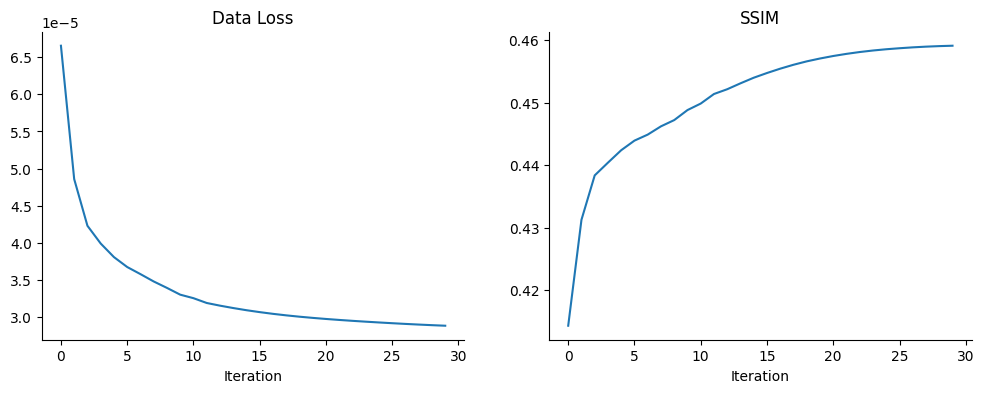

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(fwi_loss)
axs[0].set_title('Data Loss')
axs[0].set_xlabel('Iteration')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].plot(ssim_list)
axs[1].set_title('SSIM')
axs[1].set_xlabel('Iteration')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
plt.savefig(f'{exp_name}/losses.png',  bbox_inches='tight', dpi=300)

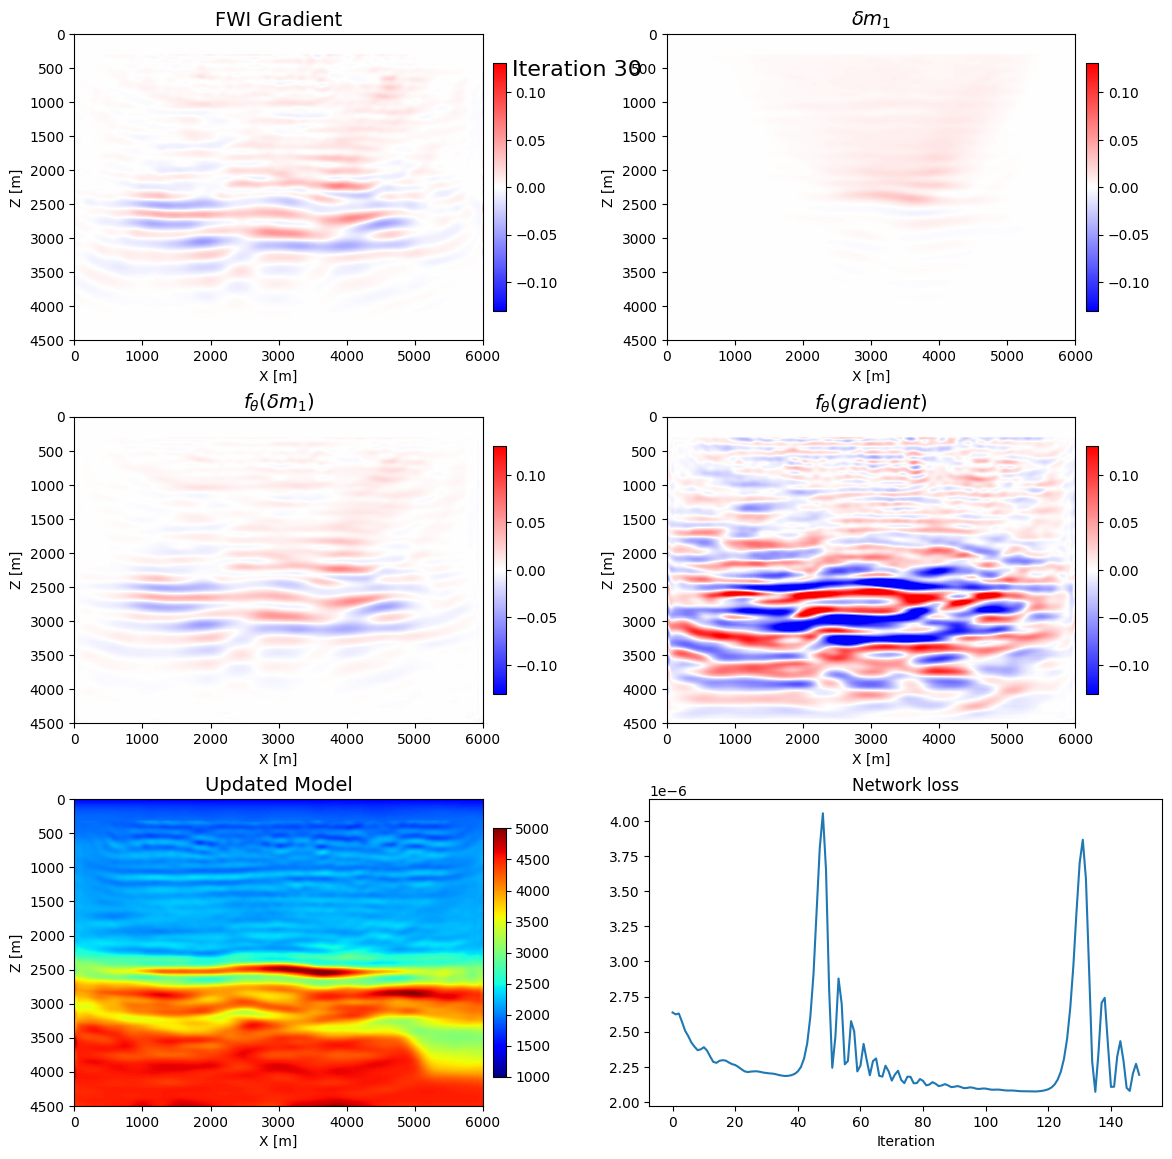

In [27]:
show_one_iter_dm(grad.cpu(), dm1.cpu(), g.cpu(), dm.cpu(), model.detach().cpu(), lossn, iteration=iteration,
                cmap='bwr', vmin=1000, vmax=5000, extent=(0, 6000, 4500, 0), save_path=f'{exp_name}')

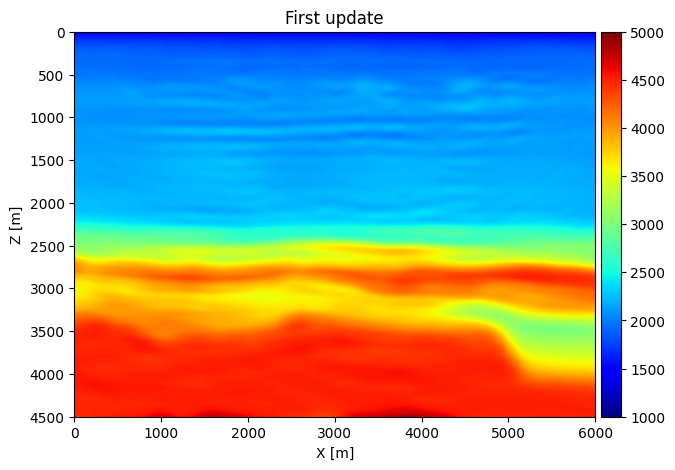

In [31]:
show_model(updates[0], cmap='jet', vmin=1000, vmax=5000, figsize=(8, 5), extent=(0, 6000, 4500, 0), title='First update')

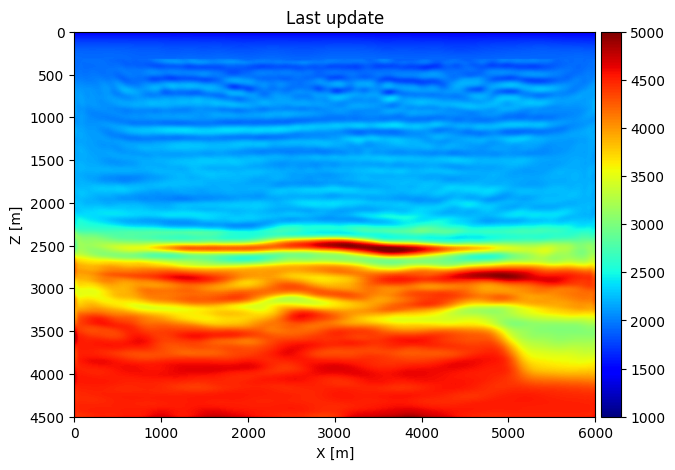

In [32]:
show_model(updates[-1], cmap='jet', vmin=1000, vmax=5000, figsize=(8, 5), extent=(0, 6000, 4500, 0), title='Last update')